In [23]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import random
import pandas as pd
import os
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
#Size of the input mammogram and 1 is for grayscale for mammogram
input_shape = (244,244,1)

In [26]:


model= Sequential([
    Input (shape=input_shape),

    #Conv Layer 2
    Conv2D(32, (3,3), padding = 'same', activation='relu'), 
    MaxPooling2D(pool_size=(2,2), strides=2),

    #Conv Layer 3
    Conv2D(64, (3,3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=2),


    #Conv Layer 4
    Conv2D(128, (3,3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=2),
    

    Conv2D(258, (3,3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=2),
    Dropout(0.3),

    
    #Flatten and Dense layer
    GlobalAveragePooling2D(),
    #Fully Connected Dense layer    
    #data regularization    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.5),
    #four class classification
    Dense(4, activation = 'softmax'),
])

In [4]:
model.compile(optimizer = Adam(learning_rate=0.0005), 
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 244, 244, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 122, 122, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 258)         │         297,474 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 258)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 258)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 258)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,982 (1.55 MB)

 Trainable params: 406,982 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
data_dir = 'resize_dataset'

total_images = 0
print("Image count per class:\n")

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))  # include common image formats
        ])
        total_images += count
        print(f"{class_name}: {count} images")

print(f"\nTotal number of images: {total_images}")s

Image count per class:

Benign: 670 images
Benign_Without_Callback: 600 images
Malignant: 703 images
Normal: 600 images

Total number of images: 2573


In [7]:


img_size = (244,244)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255,
                              # Reserve 20% of the data for validation
                             validation_split=0.2,
                             # Randomly rotate images by up to 20 degrees
                             rotation_range=20,
                             # Randomly zoom in on images by up to 20%
                             zoom_range = 0.2,
                             # Randomly change image brightness
                             brightness_range=[0.7, 1.3],
                             # Randomly shift images horizontally by 10%
                             width_shift_range=0.1,
                              # Randomly shift images vertically by 10%
                             height_shift_range=0.1,
                              # Randomly flip images horizontally
                             horizontal_flip=True,
                              # Fill in missing pixels after transformation using the nearest pixel value
                             fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training',
    shuffle = True
)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation',
    shuffle = False
)


Found 2061 images belonging to 4 classes.
Found 514 images belonging to 4 classes.


In [8]:
print(train_generator.class_indices)

{'Benign': 0, 'Benign_Without_Callback': 1, 'Malignant': 2, 'Normal': 3}


In [9]:
labels =train_generator.classes
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(weights))
print(class_weights_dict)

{0: 0.9612873134328358, 1: 1.0712058212058213, 2: 0.9151865008880995, 3: 1.0712058212058213}


In [10]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience = 10,
                           # min_delta = 1e-7,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 2,
                              verbose = 1,
                              lr=1e-6)


In [11]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=30,
                    callbacks=[early_stop],
                    class_weight = class_weights_dict)

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 598ms/step - accuracy: 0.3062 - loss: 1.4424 - val_accuracy: 0.5019 - val_loss: 1.0236
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 520ms/step - accuracy: 0.5061 - loss: 1.0381 - val_accuracy: 0.5311 - val_loss: 0.9515
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 550ms/step - accuracy: 0.5067 - loss: 0.9705 - val_accuracy: 0.5370 - val_loss: 0.8671
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 527ms/step - accuracy: 0.5265 - loss: 0.9276 - val_accuracy: 0.4961 - val_loss: 0.8673
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 611ms/step - accuracy: 0.5313 - loss: 0.9038 - val_accuracy: 0.5895 - val_loss: 0.8421
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 568ms/step - accuracy: 0.5382 - loss: 0.8932 - val_accuracy: 0.5642 - val_loss: 0.8325
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 519ms/step - accuracy: 0.5637 - loss: 0.8619 - val_accuracy: 0.6031 - val_loss: 0.8121
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 507ms/step - accuracy: 0.5685 - loss: 0.8687 - val_accu

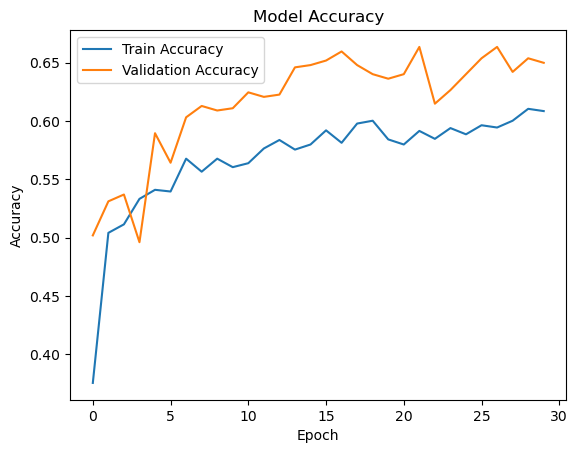

In [12]:
#plot accuracy 
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy : {val_accuracy:.4f}")
print(f"Validation Loss : {val_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4236 - loss: 0.8937
Validation Accuracy : 0.6634
Validation Loss : 0.7166


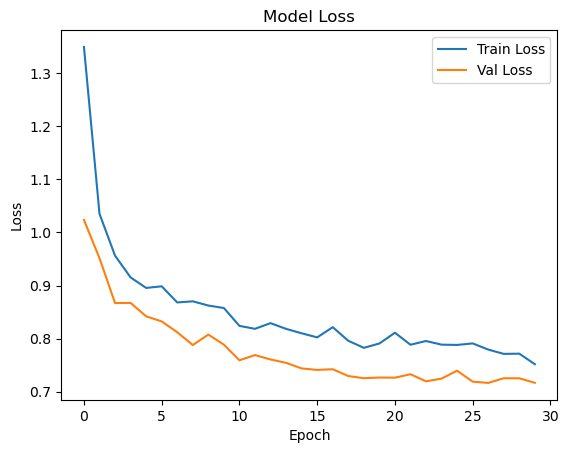

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [15]:
validation_generator.reset()
pred_probs = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis =1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


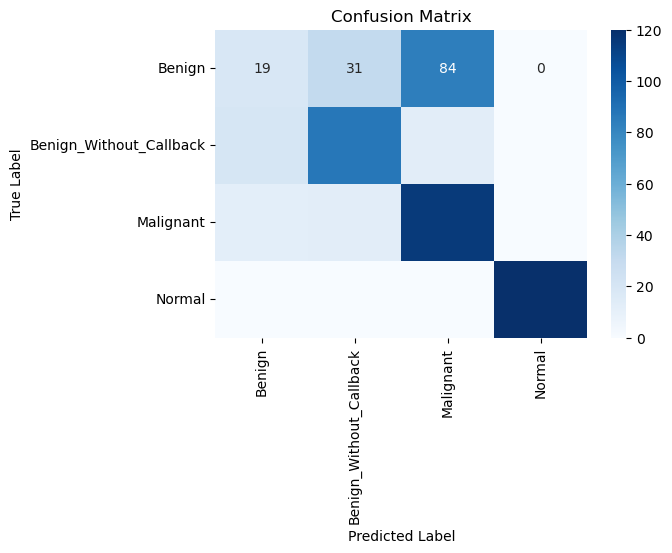

In [16]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
class_labels = ['Benign', 'Benign_Without_Callback', 'Malignant', 'Normal']

report = (classification_report(y_true, y_pred, target_names=class_labels, digits=3, output_dict = True))

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

displayed_report = df_report.loc[class_labels, ['precision', 'recall', 'f1-score', 'support']].round(3)

display(displayed_report)

,precision,recall,f1-score,support
Benign,0.373,0.142,0.205,134.0
Benign_Without_Callback,0.664,0.725,0.693,120.0
Malignant,0.542,0.821,0.653,140.0
Normal,1.000,1.000,1.000,120.0


In [18]:
model.save("custom_cnn_model.h5")

In [21]:
model = load_model("custom_cnn_model.h5")

In [24]:
img_path = 'model_prediction.gif'
img = image.load_img(img_path, target_size = (244,244), color_mode='grayscale')
img_array = image.img_to_array(img)
#rescale
img_array = img_array/255.0
#Shape(1,244,244,1)
img_array = np.expand_dims(img_array, axis = 0)

pred = model.predict(img_array)
predicted_class = np.argmax(pred)

# Show prediction and confidence
class_labels = list(train_generator.class_indices.keys())  # get class labels
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {np.max(pred):.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted class: Malignant
Confidence: 0.411


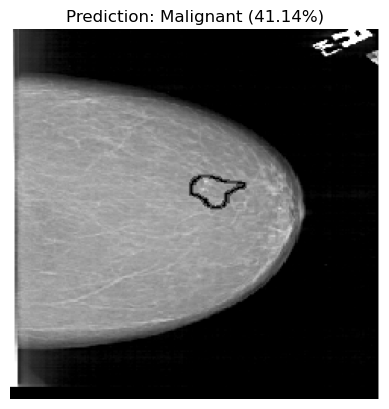

In [25]:
plt.imshow(img_array[0].squeeze(), cmap='gray')
plt.title(f"Prediction: {class_labels[predicted_class]} ({np.max(pred):.2%})")
plt.axis('off')
plt.show()w